In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [3]:
file_path = "scimagojr country rank 2024.xlsx"
df = pd.read_excel("data/scimagojr country rank 2024.xlsx")

df.head()

,Rank,Country,Region,Documents,Citable documents,Citations,Self-citations,Citations per document,H index
0,1,China,Asiatic Region,1215824,1190419,1404224,1024521,1.15,1455
1,2,United States,Northern America,743884,636319,694392,272624,0.93,3213
2,3,India,Asiatic Region,351928,302793,308228,139930,0.88,925
3,4,United Kingdom,Western Europe,252604,211490,295326,68714,1.17,2048
4,5,Germany,Western Europe,206323,185893,214421,55661,1.04,1797


In [4]:
# Keep only numeric columns
num_df = df.select_dtypes(include=[np.number])

# Drop rows with missing values (safe for country-level data)
num_df = num_df.dropna()

num_df.columns

Index(['Rank', 'Documents', 'Citable documents', 'Citations', 'Self-citations',
       'Citations per document', 'H index'],
      dtype='object')

In [5]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)

In [6]:
# Silhouette analysis for different k
silhouette_scores = {}

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores[k] = score

silhouette_scores

{2: np.float64(0.8964062163653778),
 3: np.float64(0.500183511788985),
 4: np.float64(0.54902218066063),
 5: np.float64(0.5297499520395726),
 6: np.float64(0.44025923544791173)}

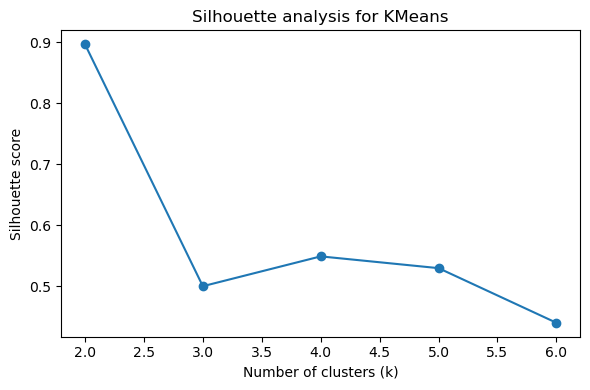

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(
    list(silhouette_scores.keys()),
    list(silhouette_scores.values()),
    marker='o'
)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis for KMeans')
plt.tight_layout()
plt.show()

In [8]:
# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

clusters = kmeans.fit_predict(X_scaled)

num_df['Cluster'] = clusters

In [9]:
# Cluster centers (excluding Cluster label)
centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=num_df.columns[:-1]
)

# Feature impact = variance across cluster centers
feature_impact = centers.var().sort_values(ascending=False)

feature_impact

Self-citations            53.251147
Citations                 40.119765
Citable documents         38.964148
Documents                 35.634020
Citations per document    19.354720
H index                    2.678427
Rank                       2.123023
dtype: float64

In [10]:
# Attach clusters back to original data
df_clustered = df.loc[num_df.index].copy()
df_clustered['Cluster'] = clusters

df_clustered[['Country', 'Cluster']].head()

,Country,Cluster
0,China,2
1,United States,1
2,India,1
3,United Kingdom,1
4,Germany,1


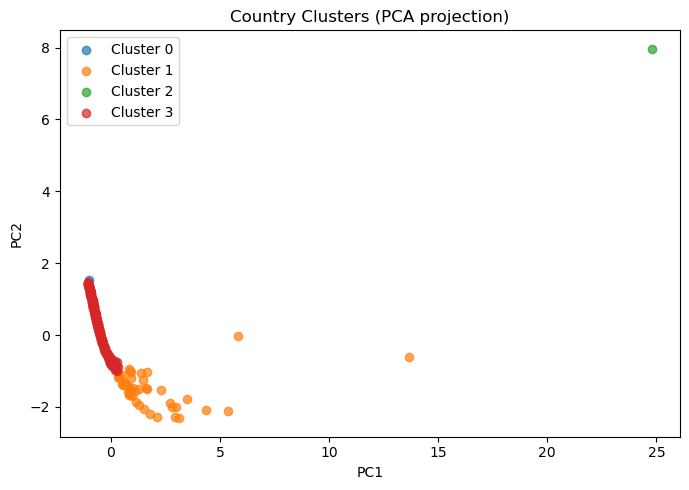

In [11]:
# Visualize clusters with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

plt.figure(figsize=(7, 5))
for c in sorted(pca_df['Cluster'].unique()):
    subset = pca_df[pca_df['Cluster'] == c]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {c}', alpha=0.7)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Country Clusters (PCA projection)')
plt.legend()
plt.tight_layout()
plt.show()